In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from IPython.display import clear_output
eps = 1e-5

In [166]:
# Load the Fashion-MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)      
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


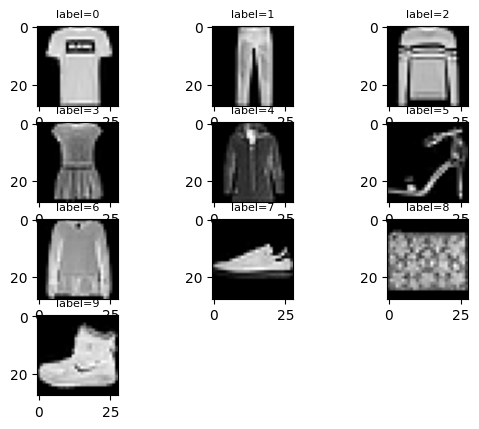

In [167]:
# Getting the unique labels and one entry from each
labels = set(y_train)
sample = {ind: np.where(y_train == ind)[0][0] for ind in labels}

# Plotting one image from each label
for i in range(10):
    plt.subplot(4,3,i+1)
    plt.imshow(x_train[sample[i]], cmap='gray')
    plt.title(f"label={i}", fontsize=8)

plt.show()


In [168]:
def one_hot_encode(y):
    one_hot_vectors = []
    for i in y:
        vec = np.zeros((10,))
        vec[i] = 1
        one_hot_vectors.append(vec)
    return np.array(one_hot_vectors)

In [169]:
# getting validation data
x_train, x_valid = x_train[:50000], x_train[50000:]
y_train, y_valid = y_train[:50000], y_train[50000:]


# reshaping the data
x_train = x_train.reshape(x_train.shape[0], 28*28)
x_train = x_train - x_train/255.0
#x_train = x_train - x_train.mean()/x_train.std()
x_valid = x_valid.reshape(x_valid.shape[0], 28*28)
x_valid = x_valid - x_valid/255.0
#x_valid = x_valid/x_valid.mean()/x_valid.std()
x_test = x_test.reshape(x_test.shape[0], 28*28)
x_test = x_test - x_test/255.0
#x_test = x_test/x_test.mean()/x_test.std()

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)

# Converting the labels to one-hot encoding
y_train = one_hot_encode(y_train)
y_valid = one_hot_encode(y_valid)
y_test = one_hot_encode(y_test)

print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 784)
x_valid shape: (10000, 784)
x_test shape: (10000, 784)
y_train shape: (50000, 10)
y_valid shape: (10000, 10)
y_test shape: (10000, 10)


In [181]:
# Activation functions
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1/(1+np.exp(-x) + eps)
def softmax(x):
    max_x = np.max(x, axis=1, keepdims=True)
    x = x - max_x
    return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)
def relu(x):
    return np.maximum(0, x)
def tanh(x):
    return np.tanh(x)


# Layer class
class Layer():
    def __init__(self, name, input_size, n_units, activation=None):
        self.n = name
        self.input_size = input_size
        self.n_units = n_units
        self.weights = None 
        self.bias = None 
        self.g = activation
        self.grad_w = None
        self.grad_b = None
        self.a = None   # Preactivatiuon
        self.h = None   # Activation

    def __call__(self, input):

        hidden = input @ self.weights.T + self.bias
        self.preact = hidden
        self.act = self.activation(hidden)
        return self.act
    
    def activation(self, z):
        if self.g == 'sigmoid':
            return sigmoid(z)
        elif self.g == 'softmax':
            return softmax(z)
        elif self.g == 'relu':
            return relu(z)
        elif self.g == 'tanh':
            return tanh(z)
        elif self.g == None:
            return z

In [219]:
# Neural Network class
class NeuralNet():
    def __init__(self, input_size, hidden_size, output_size, n_layers, loss:str, activation = ["sigmoid", "softmax"], weights_init = 'random'):
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_activation = activation[0]
        self.output_activation = activation[1]
        self.layers = self._network()
        self.initialize_weights(init_type= weights_init)
        print(self.layers[0].weights)
        self.loss_fn = loss
        self.loss = 0
    
    def random_weights(self):
        for layer in self.layers:
            layer.weights = np.random.randn(layer.n_units, layer.input_size)
            layer.bias = np.random.randn(layer.n_units)

    def xavier_weights(self):
        
        for layer in self.layers:
            input_n = layer.input_size
            output_n = layer.n_units
            low, high = -np.sqrt(6/(input_n + output_n)), np.sqrt(6/(input_n + output_n))
            layer.weights = np.random.uniform(low, high, (layer.n_units, layer.input_size))
            layer.bias = np.random.uniform(low, high, (layer.n_units))

    def initialize_weights(self, init_type = 'random'):
        if init_type == 'random':
            self.random_weights()
        elif init_type == 'xavier':
            self.xavier_weights()
        
    def _network(self):
        layers = []
        for i in range(self.n_layers):
            if i==0:
                layers.append(Layer(i, self.input_size, self.hidden_size, activation=self.hidden_activation))
            elif i < self.n_layers-1:
                layers.append(Layer(i, self.hidden_size, self.hidden_size, activation=self.hidden_activation))
            else:
                layers.append(Layer(i, self.hidden_size, self.output_size, activation=self.output_activation))
            
        return layers
    
    def get_weights(self):
        return [layer.weights for layer in self.layers]
    
    def get_biases(self):
        return [layer.bias for layer in self.layers]
       
    def __call__(self, x, y):
        for layer in self.layers:
            x = layer(x)
        
        self.loss = self.loss_fn(x, y)
        return x, self.loss_fn(x,y)
    
    def predict(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [183]:
# Loss function
class Loss():
    def __init__(self, loss_fn = 'cross_entropy'):
        self.loss_fn = loss_fn

    def __call__(self, y_true, y_pred):
        if self.loss_fn == 'cross_entropy':
            return np.mean(self.cross_entropy(y_true, y_pred))
        elif self.loss_fn == 'mse':
            return np.mean(self.mse(y_true, y_pred))
        
    def cross_entropy(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-10, 1-1e-10)
        return -np.log(np.sum(y_true*y_pred, axis=1))
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true-y_pred)**2)

In [184]:
def batch_data(x, y, batch_size):
    batches = []
    for i in range(0, x.shape[0], batch_size):
        batches.append((x[i:i+batch_size], y[i:i+batch_size]))
    return batches

In [263]:
class GradientDescent():
    def __init__(self, optimizer = 'sgd', lr = 0.01, clipping_threshold = 1e5, beta = 0.9, beta_2 = 0.999, eps = 1e-10):
        self.optimizer = optimizer
        self.lr = lr
        self.threshold = clipping_threshold
        self.eps = eps
        if self.optimizer in ['momentum', 'nag', 'rmsprop', 'adam']:    # Initiate history vectors for momentum and NAG
            self.gradw_his = {}
            self.gradb_his = {}
            self.beta = beta
        if self.optimizer == 'adam':
            self.beta_2 = beta_2
            self.gradw_m = {}
            self.gradb_m = {}



    def gradient_descent(self, model, x, y, i=0):
        
        if self.optimizer in ['sgd', 'momentum', 'rmsprop', 'adam']:      # Forward pass and backprop for SGD and Momentum
            output, loss = model(x,y)
            self.backprop(model, x, y, output)

        elif self.optimizer == 'nag':                  # Computing gradient at lookahead point before update for NAG
            for layer in model.layers:
                self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                self.gradb_his[layer.n] = [np.zeros_like(layer.bias.reshape(-1,1))]
                print(layer.n)
                print("w his, w", self.gradw_his[layer.n][-1].shape, layer.weights.shape)
                print("b his, b", self.gradb_his[layer.n][-1].shape, layer.bias.shape)
                layer.weights = layer.weights - self.beta * self.gradw_his[layer.n][-1]
                layer.bias = layer.bias - self.beta * self.gradb_his[layer.n][-1].squeeze()
                print("b after grad", layer.bias.shape)
            output, loss = model(x,y)
            self.backprop(model,x,y,output, i)            

        return loss
            


    def backprop(self, model, x, y, output):               # For computing gradients and updating weights
        grad_w, grad_b = self.compute_grads(model, x, y, output)
        self.clip_all_gradients(model, grad_w, grad_b)
        self.update_weights(model, grad_w, grad_b, i)
        
         
    def update_weights(self, model, grad_w, grad_b, i ):  
        if self.optimizer == 'sgd':                        # standard update rule for SGD
            for layer in model.layers:
                layer.weights = layer.weights - self.lr*grad_w[layer.n]
                layer.bias = layer.bias - self.lr*grad_b[layer.n].squeeze() 
        
        elif self.optimizer in ['momentum', 'nag']:       # modified update rule for Momentum and NAG
            if self.gradw_his == {} and self.gradb_his == {}:
                print("empty")
                for layer in model.layers:
                    self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                    self.gradb_his[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
            
            for layer in model.layers:
                self.gradw_his[layer.n].append(self.beta*self.gradw_his[layer.n][-1] + grad_w[layer.n])
                print("gradbhis", self.gradb_his[layer.n][-1].shape, "gradb", grad_b[layer.n].shape)
                self.gradb_his[layer.n].append(self.beta*self.gradb_his[layer.n][-1] + grad_b[layer.n])
                print(layer.n, "before update", "bias", layer.bias.shape, "bias_his", self.gradb_his[layer.n][-1].shape)
                
                layer.weights = layer.weights - self.lr*self.gradw_his[layer.n][-1]
                layer.bias = layer.bias - self.lr*self.gradb_his[layer.n][-1].squeeze()   
                print("after b update", layer.bias.shape)
            
        elif self.optimizer == 'rmsprop':
            if self.gradw_his == {} and self.gradb_his == {}:
                print("empty")
                for layer in model.layers:
                    self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                    self.gradb_his[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
            
            for layer in model.layers:
                self.gradw_his[layer.n].append(self.beta*self.gradw_his[layer.n][-1] + (1-self.beta) * grad_w[layer.n]**2)
                print("gradbhis", self.gradb_his[layer.n][-1].shape, "gradb", grad_b[layer.n].shape)
                self.gradb_his[layer.n].append(self.beta*self.gradb_his[layer.n][-1] + (1-self.beta) * grad_b[layer.n]**2)
                print(layer.n, "before update", "bias", layer.bias.shape, "bias_his", self.gradb_his[layer.n][-1].shape)
                
                layer.weights = layer.weights - (self.lr/np.sqrt(self.gradw_his[layer.n][-1] + self.eps)) * grad_w[layer.n]
                layer.bias = layer.bias - (self.lr/np.sqrt(self.gradb_his[layer.n][-1].squeeze() + self.eps)) * grad_b[layer.n].squeeze()   
                print("after b update", layer.bias.shape)

        elif self.optimizer == 'adam':
            for layer in model.layers:
                self.gradw_m[layer.n] = [np.zeros_like(layer.weights)]
                self.gradb_m[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
                self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                self.gradb_his[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
                for layer in model.layers:
                    self.gradw_m[layer.n].append(self.beta*self.gradw_m[layer.n][-1] + (1-self.beta) * grad_w[layer.n])
                    self.gradw_his[layer.n].append(self.beta_2*self.gradw_his[layer.n][-1] + (1-self.beta_2) * grad_w[layer.n]**2)
                    gradw_mhat = self.gradw_m[layer.n][-1]/(1-np.power(self.beta, i + 1))
                    gradw_vhat = self.gradw_his[layer.n][-1]/(1-np.power(self.beta_2, i + 1))

                    self.gradb_m[layer.n].append(self.beta*self.gradb_m[layer.n][-1] + (1-self.beta) * grad_b[layer.n])
                    self.gradb_his[layer.n].append(self.beta_2*self.gradb_his[layer.n][-1] + (1-self.beta_2) * grad_b[layer.n]**2)
                    gradb_mhat = self.gradb_m[layer.n][-1]/((1-np.power(self.beta, i + 1)))
                    gradb_vhat = self.gradb_his[layer.n][-1]/(1-np.power(self.beta_2, i + 1))

                    layer.weights = layer.weights - (self.lr * gradw_mhat)/(np.sqrt(gradw_vhat) + self.eps)
                    layer.bias = layer.bias - (self.lr * gradb_mhat)/(np.sqrt(gradb_vhat) + self.eps)


                
    def compute_grads(self, model, x, y, output): 
        batch_size = x.shape[0]   
        grad_a = {}
        grad_h = {}
        grad_w = {}
        grad_b = {}
        for layer in model.layers[::-1]:
            # Gradients wrt to the output layer, preactivation, activation, weights and biases
            if layer.n == model.n_layers - 1:
                grad_a[layer.n] = self.grad_output(y, output).reshape(batch_size, model.output_size, 1)
                grad_w[layer.n] = np.sum(self.grad_weights(grad_a[layer.n], model.layers[layer.n - 1].act.reshape(batch_size, model.hidden_size, 1)), axis = 0)
                grad_b[layer.n] = np.sum(self.grad_bias(grad_a[layer.n]), axis=0)
            
            # Gradients wrt to the hidden layers, preactivation, activation, weights and biases
            else:
                grad_h[layer.n] = self.grad_hidden(model.layers[layer.n + 1].weights, grad_a[layer.n + 1])
                grad_a[layer.n] = self.grad_preact(grad_h[layer.n], model.layers[layer.n].preact.reshape(batch_size, model.hidden_size, 1), model.hidden_activation)
            
            # Gradients wrt to the input layer, preactivation, activation, weights and biases
                if layer.n == 0:
                    grad_w[layer.n]= np.sum(self.grad_weights(grad_a[layer.n], x.reshape(batch_size, model.input_size, 1)), axis = 0)
                else:
                    grad_w[layer.n] = np.sum(self.grad_weights(grad_a[layer.n], model.layers[layer.n - 1].act.reshape(batch_size, model.hidden_size, 1)), axis = 0)
                grad_b[layer.n] = np.sum(self.grad_bias(grad_a[layer.n]), axis=0)
                print("-------------------")
                print(grad_b[layer.n].shape)
                print(grad_w[layer.n].shape)
                print("-------------------")

        return grad_w, grad_b


    def grad_yhat(self, y_true, y_pred, loss = 'cross_entropy'):
        if loss == 'cross_entropy':
            y_grad = np.sum(y_true * y_pred, axis=1)
        #elif loss == 'mse':
        #    y_grad = y_pred
        return -(y_true/y_grad[:, np.newaxis])


    def grad_output(self, y_true, y_pred):

        return -(y_true-y_pred)


    def grad_hidden(self, W, grad_next_preact):
        print("W shape", W.shape, "grad_next_preact shape", grad_next_preact.shape)
        print("W.T shape", W.T.shape)
        print("grad_hidden shape", (W.T @ grad_next_preact).shape)
        return W.T @ grad_next_preact


    def grad_preact(self, grad_act, act, activation):
        if activation == 'sigmoid':    # for sigmoid

            return grad_act*act*(1-act)
        elif activation == 'relu':    # for relu 
            return grad_act*(act>0)
        elif activation == 'tanh':    # for tanh
            return grad_act*(1-act**2)


    def grad_weights(self, grad_preact, input):
        print("grad preact shape", grad_preact.shape, "input shape", input.shape)
        print(input.transpose(0, 2, 1).shape)
        print("grad_weights", (grad_preact @ input.transpose(0, 2, 1)).shape)
        return grad_preact @ input.transpose(0, 2, 1) 


    def grad_bias(self, grad_preact):
        return grad_preact
    

            
    def clip_gradients(self, gradients):
        return np.clip(gradients, -self.threshold, self.threshold)

    def clip_all_gradients(self, model, grad_w, grad_b):
        for layer in model.layers:
            grad_w[layer.n]= self.clip_gradients(grad_w[layer.n])
            grad_b[layer.n] = self.clip_gradients(grad_b[layer.n])
    
    
    def check_for_nans(self, array):
        if np.isnan(array).any():
            raise ValueError("NaN detected in array")




In [264]:
batch_size = 32
threshold = 1e5
loss = Loss(loss_fn='cross_entropy')
optimizer = GradientDescent(optimizer='adam', lr=0.0001, clipping_threshold=threshold, beta=0.9, beta_2 = 0.999, eps = 1e-10)
model = NeuralNet(input_size=x_train.shape[1], hidden_size=128, output_size=10, n_layers=6, loss=loss, activation=["sigmoid", "softmax"], weights_init = 'xavier')

[[-0.00980938  0.05231481  0.07951483 ...  0.03083408  0.07037796
  -0.01911326]
 [ 0.02737596 -0.06407934  0.07916729 ... -0.01785607  0.05713456
   0.04216583]
 [ 0.05561156  0.03347174 -0.03103828 ... -0.03534295 -0.02589258
   0.00542836]
 ...
 [-0.01553189  0.05132416  0.0594729  ... -0.06577956  0.0535148
  -0.03928817]
 [ 0.06192958  0.04812674  0.04570118 ... -0.01969502  0.06877886
   0.00475378]
 [ 0.04530453  0.05228169 -0.06432638 ... -0.05084975  0.0572529
  -0.01499512]]


In [265]:
import copy
train = batch_data(x_train, y_train, batch_size)
valid = batch_data(x_valid, y_valid, batch_size)
train_losses = []
valid_losses = []
for epoch in range(10):
    i=0
    print(f"Epoch: {epoch}")
    batch_train_loss = []
    batch_valid_loss = []
    for (x,y),  (x_val, y_val) in zip(train, valid):

        loss = optimizer.gradient_descent(model, x, y, i)
        #loss = copy.deepcopy(model.loss)
        i+=1
        if i%1000 == 0:
            print(f"batch {i} loss: {loss}")
        batch_train_loss.append(loss)
        

        valid_output = model(x_val, y_val)
        valid_loss = model.loss
        if i%1000 == 0:
            print(f"validation loss: {valid_loss}")
        batch_valid_loss.append(valid_loss)
    #clear_output(True)
    print(f"average train loss in epoch {epoch}: {np.mean(batch_train_loss)}")
    print(f"average valid loss in epoch {epoch}: {np.mean(batch_valid_loss)}")

    train_losses.append(np.mean(batch_train_loss))
    valid_losses.append(np.mean(batch_valid_loss))


Epoch: 0
grad preact shape (32, 10, 1) input shape (32, 128, 1)
(32, 1, 128)
grad_weights (32, 10, 128)
W shape (10, 128) grad_next_preact shape (32, 10, 1)
W.T shape (128, 10)
grad_hidden shape (32, 128, 1)
grad preact shape (32, 128, 1) input shape (32, 128, 1)
(32, 1, 128)
grad_weights (32, 128, 128)
-------------------
(128, 1)
(128, 128)
-------------------
W shape (128, 128) grad_next_preact shape (32, 128, 1)
W.T shape (128, 128)
grad_hidden shape (32, 128, 1)
grad preact shape (32, 128, 1) input shape (32, 128, 1)
(32, 1, 128)
grad_weights (32, 128, 128)
-------------------
(128, 1)
(128, 128)
-------------------
W shape (128, 128) grad_next_preact shape (32, 128, 1)
W.T shape (128, 128)
grad_hidden shape (32, 128, 1)
grad preact shape (32, 128, 1) input shape (32, 128, 1)
(32, 1, 128)
grad_weights (32, 128, 128)
-------------------
(128, 1)
(128, 128)
-------------------
W shape (128, 128) grad_next_preact shape (32, 128, 1)
W.T shape (128, 128)
grad_hidden shape (32, 128, 1)


KeyError: 1

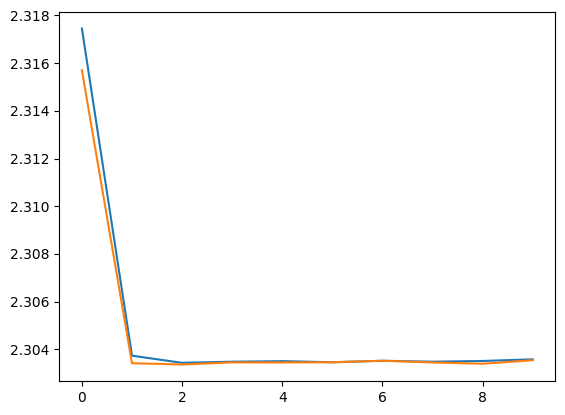

In [250]:
plt.plot(train_losses)
plt.plot(valid_losses)

In [ ]:
#TODO adam nadam
#TODO xavier ------
#TODO wandb
#TODO weight decay?
#TODO MSE


In [94]:
# xavier

lower, upper = -np.sqrt(6/(10 + 10)), np.sqrt(6/(10 + 10))
weights = np.random.uniform(lower, upper, (10, 10))
print(weights)

[[-0.1782536  -0.43854809 -0.36862793  0.23588074  0.04759322 -0.43390077
   0.28412038  0.47865146  0.27165991  0.11677319]
 [ 0.13909657 -0.30711235 -0.12388476  0.13952338  0.45907149  0.11155546
   0.2853592  -0.16885772  0.40098829  0.22731911]
 [-0.11951977 -0.49173405 -0.10321713  0.30821985 -0.32278034 -0.22750197
  -0.21816761 -0.33235986 -0.39814216  0.2852935 ]
 [-0.45694659  0.51300106 -0.48978955  0.45721985  0.32134168 -0.12544747
  -0.12901372 -0.05735845 -0.53600901 -0.25215001]
 [ 0.3327438  -0.28570445 -0.30616321 -0.13689553  0.26848166 -0.44535641
   0.17893223  0.50172762  0.453385   -0.39102195]
 [-0.09787849  0.11321479  0.06700675  0.20229099  0.08896336 -0.27898374
   0.10908383 -0.46535807 -0.36238803  0.0268404 ]
 [-0.46909389  0.3416801   0.43480037 -0.24421008 -0.05715687 -0.1629836
  -0.34273283 -0.34739429  0.42539277  0.00902916]
 [-0.41758449 -0.49762803 -0.45779233  0.50583236  0.23878136 -0.2865875
   0.33237194 -0.54755339  0.33901397  0.41024444]
 [

In [ ]:
class GradientDescent():
    def __init__(self, optimizer = 'sgd', lr = 0.01, clipping_threshold = 1e5, beta = 0.9, eps = 1e-10, beta_2 = None):
        self.optimizer = optimizer
        self.lr = lr
        self.threshold = clipping_threshold
        self.eps = eps
        if self.optimizer in ['momentum', 'nag', 'rmsprop']:    # Initiate history vectors for momentum and NAG
            self.gradw_his = {}
            self.gradb_his = {}
            self.beta = beta
        if self.optimizer == 'adam':
            self.beta_2 = beta_2
            self.gradw_m = {}
            self.gradb_m = {}


    def gradient_descent(self, model, x, y):
        
        if self.optimizer in ['sgd', 'momentum', 'rmsprop']:      # Forward pass and backprop for SGD and Momentum
            output = model(x,y)
            self.backprop(model, x, y, output)

        elif self.optimizer == 'nag':                  # Computing gradient at lookahead point before update
            for layer in model.layers:
                self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                self.gradb_his[layer.n] = [np.zeros_like(layer.bias.reshape(-1,1))]
                print(layer.n)
                print("w his, w", self.gradw_his[layer.n][-1].shape, layer.weights.shape)
                print("b his, b", self.gradb_his[layer.n][-1].shape, layer.bias.shape)
                layer.weights = layer.weights - self.beta * self.gradw_his[layer.n][-1]
                layer.bias = layer.bias - self.beta * self.gradb_his[layer.n][-1].squeeze()
                print("b after grad", layer.bias.shape)
            output = model(x,y)
            self.backprop(model,x,y,output)            
            


    def backprop(self, model, x, y, output):               # For computing gradients and updating weights
        grad_w, grad_b = self.compute_grads(model, x, y, output)
        self.clip_all_gradients(model, grad_w, grad_b)
        self.update_weights(model, grad_w, grad_b)
        
         
    def update_weights(self, model, grad_w, grad_b):  
        if self.optimizer == 'sgd':                        # standard update rule for SGD
            for layer in model.layers:
                layer.weights = layer.weights - self.lr*grad_w[layer.n]
                layer.bias = layer.bias - self.lr*grad_b[layer.n].squeeze() 
        
        elif self.optimizer in ['momentum', 'nag']:       # modified update rule for Momentum and NAG
            if self.gradw_his == {} and self.gradb_his == {}:
                print("empty")
                for layer in model.layers:
                    self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                    self.gradb_his[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
            
            for layer in model.layers:
                self.gradw_his[layer.n].append(self.beta*self.gradw_his[layer.n][-1] + grad_w[layer.n])
                print("gradbhis", self.gradb_his[layer.n][-1].shape, "gradb", grad_b[layer.n].shape)
                self.gradb_his[layer.n].append(self.beta*self.gradb_his[layer.n][-1] + grad_b[layer.n])
                print(layer.n, "before update", "bias", layer.bias.shape, "bias_his", self.gradb_his[layer.n][-1].shape)
                
                layer.weights = layer.weights - self.lr*self.gradw_his[layer.n][-1]
                layer.bias = layer.bias - self.lr*self.gradb_his[layer.n][-1].squeeze()   
                print("after b update", layer.bias.shape)
            
        elif self.optimizer == 'rmsprop':
            if self.gradw_his == {} and self.gradb_his == {}:
                print("empty")
                for layer in model.layers:
                    self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                    self.gradb_his[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
            
            for layer in model.layers:
                self.gradw_his[layer.n].append(self.beta*self.gradw_his[layer.n][-1] + (1-self.beta) * grad_w[layer.n]**2)
                print("gradbhis", self.gradb_his[layer.n][-1].shape, "gradb", grad_b[layer.n].shape)
                self.gradb_his[layer.n].append(self.beta*self.gradb_his[layer.n][-1] + (1-self.beta) * grad_b[layer.n]**2)
                print(layer.n, "before update", "bias", layer.bias.shape, "bias_his", self.gradb_his[layer.n][-1].shape)
                
                layer.weights = layer.weights - (self.lr/np.sqrt(self.gradw_his[layer.n][-1] + self.eps)) * grad_w[layer.n]
                layer.bias = layer.bias - (self.lr/np.sqrt(self.gradb_his[layer.n][-1].squeeze() + self.eps)) * grad_b[layer.n].squeeze()   
                print("after b update", layer.bias.shape)


        elif self.optimizer == 'adam':
            for layer in model.layers:
                self.gradw_m[layer.n] = [np.zeros_like(layer.weights)]
                self.gradb_m[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
                for layer in model.layers:
                    self.gradw_m[layer.n].append(self.beta*self.gradw_m[layer.n][-1] + (1-self.beta) * grad_w[layer.n])
                    self.gradw_his[layer.n].append(self.beta_2*self.gradw_his[layer.n][-1] + (1-self.beta_2) * grad_w[layer.n]**2)
                    gradw_mhat = self.gradw_m[layer.n][-1]/(1-np.power(self.beta, i + 1))
                    gradw_vhat = self.gradw_his[layer.n][-1]/(1-np.power(self.beta_2, i + 1))

                    self.gradb_m[layer.n].append(self.beta*self.gradb_m[layer.n][-1] + (1-self.beta) * grad_b[layer.n])
                    self.gradb_his[layer.n].append(self.beta_2*self.gradb_his[layer.n][-1] + (1-self.beta_2) * grad_b[layer.n]**2)
                    gradb_mhat = self.gradb_m[layer.n][-1]/((1-np.power(self.beta, i + 1)))
                    gradb_vhat = self.gradb_his[layer.n][-1]/(1-np.power(self.beta_2, i + 1))

                    layer.weights = layer.weights - (self.lr * gradw_mhat)/(np.sqrt(gradw_vhat) + self.eps)
                    layer.bias = layer.bias - (self.lr * gradb_mhat)/(np.sqrt(gradb_vhat) + self.eps)


                
    def compute_grads(self, model, x, y, output): 
        batch_size = x.shape[0]   
        grad_a = {}
        grad_h = {}
        grad_w = {}
        grad_b = {}
        for layer in model.layers[::-1]:
            # Gradients wrt to the output layer, preactivation, activation, weights and biases
            if layer.n == model.n_layers - 1:
                grad_a[layer.n] = self.grad_output(y, output).reshape(batch_size, model.output_size, 1)
                grad_w[layer.n] = np.sum(self.grad_weights(grad_a[layer.n], model.layers[layer.n - 1].act.reshape(batch_size, model.hidden_size, 1)), axis = 0)
                grad_b[layer.n] = np.sum(self.grad_bias(grad_a[layer.n]), axis=0)
            
            # Gradients wrt to the hidden layers, preactivation, activation, weights and biases
            else:
                grad_h[layer.n] = self.grad_hidden(model.layers[layer.n + 1].weights, grad_a[layer.n + 1])
                grad_a[layer.n] = self.grad_preact(grad_h[layer.n], model.layers[layer.n].preact.reshape(batch_size, model.hidden_size, 1), model.hidden_activation)
            
            # Gradients wrt to the input layer, preactivation, activation, weights and biases
                if layer.n == 0:
                    grad_w[layer.n]= np.sum(self.grad_weights(grad_a[layer.n], x.reshape(batch_size, model.input_size, 1)), axis = 0)
                else:
                    grad_w[layer.n] = np.sum(self.grad_weights(grad_a[layer.n], model.layers[layer.n - 1].act.reshape(batch_size, model.hidden_size, 1)), axis = 0)
                grad_b[layer.n] = np.sum(self.grad_bias(grad_a[layer.n]), axis=0)
        
        return grad_w, grad_b


    def grad_yhat(self, y_true, y_pred, loss = 'cross_entropy'):
        if loss == 'cross_entropy':
            y_grad = np.sum(y_true * y_pred, axis=1)
        #elif loss == 'mse':
        #    y_grad = y_pred
        return -(y_true/y_grad[:, np.newaxis])


    def grad_output(self, y_true, y_pred):
        return -(y_true-y_pred)


    def grad_hidden(self, W, grad_next_preact):
        return W.T @ grad_next_preact


    def grad_preact(self, grad_act, act, activation):
        if activation == 'sigmoid':    # for sigmoid
            return grad_act*act*(1-act)
        elif activation == 'relu':    # for relu 
            return grad_act*(act>0)
        elif activation == 'tanh':    # for tanh
            return grad_act*(1-act**2)


    def grad_weights(self, grad_preact, input):
        return grad_preact @ input.transpose(0, 2, 1) 


    def grad_bias(self, grad_preact):
        return grad_preact
    

            
    def clip_gradients(self, gradients):
        return np.clip(gradients, -self.threshold, self.threshold)

    def clip_all_gradients(self, model, grad_w, grad_b):
        for layer in model.layers:
            grad_w[layer.n]= self.clip_gradients(grad_w[layer.n])
            grad_b[layer.n] = self.clip_gradients(grad_b[layer.n])
    
    
    def check_for_nans(self, array):
        if np.isnan(array).any():
            raise ValueError("NaN detected in array")


